<a href="https://colab.research.google.com/github/koleshjr/SWAHILI-WORDS-VOICE-RECOGNITION/blob/main/Swahili_solution_(tts).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install fastai --upgrade --q
!pip install fastaudio --q
exit()

     |████████████████████████████████| 225 kB 5.2 MB/s 
     |████████████████████████████████| 1.9 MB 6.9 MB/s 
     |████████████████████████████████| 53 kB 3.0 MB/s 
     |████████████████████████████████| 183 kB 78.8 MB/s 
     |████████████████████████████████| 194 kB 46.6 MB/s 
     |████████████████████████████████| 804.1 MB 2.7 kB/s 
     |████████████████████████████████| 19.1 MB 1.0 MB/s 
     |████████████████████████████████| 19.1 MB 1.1 MB/s 
     |████████████████████████████████| 21.0 MB 1.2 MB/s 
     |████████████████████████████████| 23.2 MB 1.3 MB/s 
     |████████████████████████████████| 23.3 MB 85.7 MB/s 
     |████████████████████████████████| 23.3 MB 98.8 MB/s 
     |████████████████████████████████| 22.1 MB 1.3 MB/s 
     |████████████████████████████████| 22.1 MB 1.3 MB/s 
     |████████████████████████████████| 17.4 MB 56.9 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the s

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%time
!unzip -o -q '/content/drive/MyDrive/swahili_audio_classification/Swahili_words.zip' -d "/content/Swahili_words"

CPU times: user 99.2 ms, sys: 13.9 ms, total: 113 ms
Wall time: 15.9 s


In [ ]:
import os
import random
import warnings
from fastai.vision.all import *
from fastaudio.core.all import *
from fastaudio.augment.all import *
import torch

path = "/content/drive/MyDrive/swahili_audio_classification/"
warnings.filterwarnings('ignore')


/usr/local/lib/python3.7/dist-packages/torchaudio/backend/utils.py:47: UserWarning: "torchaudio.USE_SOUNDFILE_LEGACY_INTERFACE" flag is deprecated and will be removed in 0.9.0. Please remove the use of flag.
  '"torchaudio.USE_SOUNDFILE_LEGACY_INTERFACE" flag is deprecated and will be removed in 0.9.0. '


In [ ]:
# AddNoiseGPU, ChangeVolumeGPU, DeltaGPU, MaskFreqGPU, MaskTimeGPU, SignalCutoutGPU, SignalLossGPU, TfmResizeGPU
# help(TfmResizeGPU)

In [ ]:
train = pd.read_csv(path+"Train.csv")
test = pd.read_csv(path+"Test.csv")
ss = pd.read_csv(path+"SampleSubmission.csv")

train

,Word_id,Swahili_word,English_translation
0,id_v8rz06e6rv31.wav,mbili,two
1,id_vmbwicdpfn68.wav,tatu,three
2,id_injlouhxg1hg.wav,ndio,yes
3,id_gdq23p6xgzya.wav,nne,four
4,id_lpstklz51zpz.wav,nane,eight
...,...,...,...
4195,id_ho8aqa3s42zp.wav,hapana,no
4196,id_3lhkgf9dqr4c.wav,kumi,ten
4197,id_ixb7vv4i0zct.wav,tano,five
4198,id_7tboov3kavg4.wav,nne,four


In [ ]:
train["Word_id"] = "/content/Swahili_words/" + train["Word_id"]
test["Word_id"] = "/content/Swahili_words/" + test["Word_id"]

In [ ]:
def random_seed(seed_value, use_cuda): 
   np.random.seed(seed_value)
   torch.manual_seed(seed_value) 

   random.seed(seed_value)

   if use_cuda: 
      torch.cuda.manual_seed(seed_value) 
      torch.cuda.manual_seed_all(seed_value) 

      torch.backends.cudnn.deterministic = True 

      torch.backends.cudnn.benchmark = False 

random_seed(2022, True)
set_seed(2022, True)

In [ ]:
augs = [
        AddNoiseGPU, ChangeVolumeGPU, DeltaGPU, MaskFreqGPU, MaskTimeGPU, SignalCutoutGPU, SignalLossGPU, TfmResizeGPU
]

In [ ]:
params = {'n_mels':64}
cfg = AudioConfig.BasicMelSpectrogram(**params) # pull up the voice config
aud2spec = AudioToSpec.from_cfg(cfg) # let audio to spec use the config

In [ ]:
class AudioNormalize(Transform):
    "Normalizes a single `AudioTensor`."
    def encodes(self, x:AudioTensor): return (x-x.mean()) / x.std()

In [ ]:
audio = DataBlock(blocks=(AudioBlock(force_mono=True, crop_signal_to=4500), 
                          CategoryBlock),
                      splitter=TrainTestSplitter(0.05, stratify=train["Swahili_word"], shuffle = 65253, random_state=2022),
                      get_x = ColReader(0),
                      get_y=ColReader(1),
                      item_tfms = [AudioNormalize],
                      batch_tfms = [aud2spec, ChangeVolumeGPU, SignalLossGPU]        
    )

In [ ]:
dls = audio.dataloaders(train, bs=32, num_workers=0, device='cuda')
dls.rng.seed(2022)

In [ ]:
learn = cnn_learner(dls, resnet50, CrossEntropyLossFlat(), metrics=accuracy, n_in=1)

0.012022644281387329


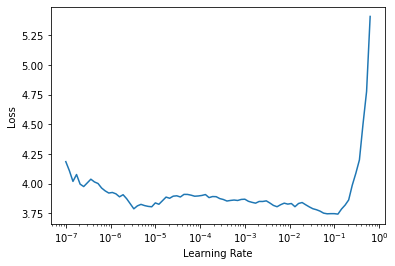

In [ ]:
lr = learn.lr_find()[0]
print(lr)

In [ ]:
callbacks = [
            # EarlyStoppingCallback(monitor='valid_loss', min_delta=0.05, patience=4),
             SaveModelCallback(monitor='valid_loss') 
             ]
learn.fine_tune(12, wd=0.1, base_lr=lr, cbs=callbacks)

epoch,train_loss,valid_loss,accuracy,time
0,2.641793,2.127775,0.428571,00:32


Better model found at epoch 0 with valid_loss value: 2.127775192260742.


epoch,train_loss,valid_loss,accuracy,time
0,0.619518,0.400031,0.885714,00:39
1,0.437004,0.437206,0.876190,00:40
2,0.424718,0.314850,0.909524,00:40
3,0.356089,0.388938,0.880952,00:39
4,0.239093,0.371434,0.919048,00:40
5,0.207394,0.242640,0.928571,00:39
6,0.149282,0.197719,0.938095,00:40
7,0.114437,0.167660,0.952381,00:39
8,0.106469,0.139726,0.966667,00:40
9,0.082663,0.103311,0.961905,00:40


Better model found at epoch 0 with valid_loss value: 0.4000309407711029.
Better model found at epoch 2 with valid_loss value: 0.31485021114349365.
Better model found at epoch 5 with valid_loss value: 0.24263961613178253.
Better model found at epoch 6 with valid_loss value: 0.19771906733512878.
Better model found at epoch 7 with valid_loss value: 0.1676599234342575.
Better model found at epoch 8 with valid_loss value: 0.13972628116607666.
Better model found at epoch 9 with valid_loss value: 0.10331077873706818.
Better model found at epoch 10 with valid_loss value: 0.0908915176987648.
Better model found at epoch 11 with valid_loss value: 0.08777874708175659.


In [ ]:
# lr = learn.lr_find()[0]
# print(lr)

In [ ]:
# learn.fine_tune(10, wd=0.1, base_lr=lr, cbs=callbacks)

In [ ]:
# lr = learn.lr_find()[0]
# print(lr)

In [ ]:
# learn.fine_tune(5, wd=0.01, base_lr=lr, cbs=callbacks)

```
epoch 	train_loss 	valid_loss 	accuracy 	time
0 	1.444286 	1.089325 	0.668163 	08:18
1 	1.064188 	0.869083 	0.728936 	08:19
2 	0.866237 	0.765316 	0.763812 	08:18
3 	0.701694 	0.697653 	0.780041 	08:23
4 	0.556303 	0.620731 	0.806975 	08:20
5 	0.495780 	0.636264 	0.809392 	08:25
6 	0.354235 	0.619374 	0.821478 	08:22
7 	0.250819 	0.633827 	0.822169 	08:14

No improvement since epoch 4: early stopping

```

In [ ]:
# learn.unfreeze()
# learn.fine_tune(3, wd=0.1, base_lr=lr, cbs=callbacks)
# # learn.fit_one_cycle(3, lr_max=slice(1e-6,1e-4))

In [ ]:
# learn.unfreeze()
# learn.fine_tune(2, wd=0.1, base_lr=lr, cbs=callbacks)
# # learn.fit_one_cycle(3, lr_max=slice(1e-6,1e-5))

In [ ]:
tdl = learn.dls.test_dl(test["Word_id"]) # quicly create test data loader
test_preds_tta, test_labels_tta = learn.tta(dl=tdl, n=10)

In [ ]:
ss[ss.columns[1:]] = test_preds_tta
ss.head()

,Word_id,hapana,kumi,mbili,moja,nane,ndio,nne,saba,sita,tano,tatu,tisa
0,id_jp2pxl0r84ya.wav,3.445582e-07,1.783333e-07,1.657284e-06,2.940470e-06,3.628748e-07,2.491380e-05,4.880637e-06,5.699742e-06,9.999565e-01,3.848114e-07,6.001011e-07,1.503883e-06
1,id_ndduqqvthbpx.wav,8.880914e-09,1.878523e-08,4.015437e-09,7.618248e-10,2.417528e-08,1.169324e-09,1.092636e-09,7.952422e-09,3.525249e-09,5.649542e-08,8.813495e-09,9.999999e-01
2,id_36oxymxfcm6q.wav,1.540861e-06,9.318959e-06,8.571685e-07,1.454236e-06,3.387828e-06,6.571866e-07,5.610405e-07,9.271092e-07,2.176834e-06,8.479898e-06,1.880938e-06,9.999688e-01
3,id_ue9b0to760pg.wav,1.321413e-05,1.136568e-06,1.271602e-07,7.450243e-08,2.181056e-06,4.399706e-06,1.034619e-06,1.440637e-06,1.713531e-06,9.999729e-01,1.327094e-06,3.336706e-07
4,id_prja4oprb914.wav,8.570924e-02,3.649833e-02,3.115756e-02,9.171913e-02,4.568528e-01,4.863097e-02,7.306726e-03,5.627425e-02,5.463742e-02,3.728841e-02,5.091821e-02,4.300697e-02


In [ ]:
name = "baseline_swahili_10.csv"
ss.to_csv(name, index=False)
from google.colab import files
files.download(name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from sklearn.metrics import log_loss 

val = pd.read_csv(path+'Validation.csv')[['Word_id', 'Swahili_word']]
chk = ss[ss.Word_id.apply(lambda x:x in val.Word_id.unique())]

log_loss(val.Swahili_word, chk[chk.columns[1:]])
#0.07689922083103892

0.06077343931809228

In [ ]:
# name = "/content/second-res50-recovery2.csv"
# ss.to_csv(name, index=False)